# Phase 2: Classification Prediction with Imbalanced Target

## Mary Donovan Martello

**Phase 1 of the credit card default project involved testing five binary classification models for predicting credit card defaults.  Phase 1 can be found:** [here](https://github.com/MaryDonovanMartello/Credit-Card-Default-Prediction)

**Phase 2 of the credit card default project includes (1) employing methodologies other than Principal Component Analysis to address multicollinearity and feature selection in an effort to be able to analyze individual factors that are significant for defaults, (2) testing multiple approaches to addressing an imbalanced target variable in a binary classification model, and (3) implementing deployment models to make actual predictions and convert the logistic regression coefficients to a risk score that can be used in making lending decisions.**

## Part 3:  Approach to Imbalanced Target:  Predicted Probabilities/Optimize Threshold

In [2]:
# import libraries

import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import mean
from numpy import std
from numpy import argmax

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, f1_score, recall_score, log_loss


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#stop unnecessary warnings from printing to the screen
import warnings
warnings.simplefilter('ignore')



### This notebook uses two datasets that were cleaned and prepared in the 1_EDA_Prep notebook.  One of the datasets replaces some of the original variables with the Months_Late engineered features and the second dataset replaces some of the original variables with both the Months_Late and Payment_Ratio engineered features.

In [3]:
# Load data into a dataframe
#df = pd.read_csv('pcaDefault.csv')

# Load best subset data into a dataframe
#subset7 = pd.read_csv('subset7df.csv')

# Load data into a dataframe
df1 = pd.read_csv('logDefaultRev1.csv')
df2 = pd.read_csv('logDefaultRev2.csv')


**Create feature dataframes for modeling.**

In [4]:
#df1

# separate into input and output columns (X variable for features and y for target variables)

X1 = df1.drop('default', axis = 1) 
y1 = df1['default']

In [5]:
#df1 subset

# separate into input and output columns (X variable for features and y for target variables)

X1s = df1.loc[:, ['MONTHS_LATE', 'LIMIT_BAL', 'AGE']] 
y1s = df1['default']

In [6]:
#df1

# one-hot encode input categorical variables
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [0, 1, 2])], remainder='passthrough')
X1 = transformer.fit_transform(X1)



In [7]:
#df2

# separate into input and output columns (X variable for features and y for target variables)

X2 = df2.drop('default', axis = 1) 
y2 = df2['default']

In [8]:
#df2 subset

# separate into input and output columns (X variable for features and y for target variables)

X2s = df2.loc[:, ['MONTHS_LATE', 'PAYMENT_RATIO',]] 
y2s = df2['default']

In [9]:
#df2

# one-hot encode input categorical variables
transformer = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [0, 1, 2])], remainder='passthrough')
X2 = transformer.fit_transform(X2)

**Split data**

In [11]:
# separate data into training and test data
X1Train, X1Test, y1Train, y1Test = train_test_split(X1, y1, test_size =0.2, random_state=1)


In [41]:
# separate data into training and test data
X2Train, X2Test, y2Train, y2Test = train_test_split(X2, y2, test_size =0.2, random_state=1)

In [46]:
# separate data into training and test data
X1sTrain, X1sTest, y1sTrain, y1sTest = train_test_split(X1s, y1s, test_size =0.2, random_state=1)

In [14]:
# separate data into training and test data
X2sTrain, X2sTest, y2sTrain, y2sTest = train_test_split(X2s, y2s, test_size =0.2, random_state=1)

**Pipeline to scale data and tune Logistic Regression model**

In [18]:
# grid search in a pipeline with logistic regression

# define pipeline
from sklearn.preprocessing import StandardScaler
trans = StandardScaler()
model = LogisticRegression()
from sklearn.pipeline import Pipeline
pipeline=Pipeline([('t', trans), ('m', model)])

# set paramaters to be tested in the grid search
params = {'m__C': [1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04],
            'm__penalty': ['l1', 'l2']}

# set cross-validation technique
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# tune the model
from sklearn.metrics import make_scorer, f1_score, recall_score, log_loss
lr_grid=GridSearchCV(pipeline, params, verbose=2,
          cv=skf, scoring={'avr': make_scorer(recall_score, needs_proba=False),
                                'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)}, 
                    refit='avr', n_jobs=-1)



**Fit model for 4 different subsets of data**

In [19]:
# X1 df
# fit the tuned model
lr_grid.fit(X1Train, y1Train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('t', StandardScaler(copy=True, with_mean=True, with_std=True)), ('m', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'m__C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'm__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

In [42]:
# X2 df
# fit the tuned model
lr_grid.fit(X2Train, y2Train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('t', StandardScaler(copy=True, with_mean=True, with_std=True)), ('m', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'m__C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'm__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

In [47]:
# X1 df subset
# fit the tuned model
lr_grid.fit(X1sTrain, y1sTrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('t', StandardScaler(copy=True, with_mean=True, with_std=True)), ('m', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'m__C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'm__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

In [53]:
# X2 df subset
# fit the tuned model
lr_grid.fit(X2sTrain, y2sTrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('t', StandardScaler(copy=True, with_mean=True, with_std=True)), ('m', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'m__C': [1.0, 2.7825594, 7.74263683, 21.5443469, 59.948425, 166.810054, 464.158883, 1291.54967, 3593.81366, 10000.0], 'm__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='avr', return_train_score='warn',
       scoring={'avr': make_scorer(recall_score), 'll': make_scorer(log_loss, greater_is_better=False, needs_proba=True)},
       verbose=2)

**Probability Predictions and Classification Threshold Selection**

Make probability predictions to choose best classification threshold for imbalanced target

Duplicate for each of four subsets of data.

In [21]:
# choose the threshold with the Receiver Operating Characteristic curve and Youden's J statistic

# predict probabilities; the last part of this line keeps the probabilities for the positive outcome only
predprob1=lr_grid.predict_proba(X1Test)[:,1]

# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y1Test, predprob1)

# get the best threshold: Youden’s J statistic
J = tpr - fpr
from numpy import argmax
ix = argmax(J)
best_thresh1 = thresholds[ix]
print('Best Threshold=%f' % (best_thresh1))

Best Threshold=0.257852


In [44]:
# choose the threshold with the Receiver Operating Characteristic curve and Youden's J statistic

# predict probabilities; the last part of this line keeps the probabilities for the positive outcome only
predprob2=lr_grid.predict_proba(X2Test)[:,1]

# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y2Test, predprob2)

# get the best threshold: Youden’s J statistic
J = tpr - fpr
from numpy import argmax
ix = argmax(J)
best_thresh2 = thresholds[ix]
print('Best Threshold=%f' % (best_thresh2))

Best Threshold=0.265626


In [49]:
# choose the threshold with the Receiver Operating Characteristic curve and Youden's J statistic

# predict probabilities; the last part of this line keeps the probabilities for the positive outcome only
predprob1s=lr_grid.predict_proba(X1sTest)[:,1]

# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y1sTest, predprob1s)

# get the best threshold: Youden’s J statistic
J = tpr - fpr
from numpy import argmax
ix = argmax(J)
best_thresh1s = thresholds[ix]
print('Best Threshold=%f' % (best_thresh1s))

Best Threshold=0.231867


In [55]:
# choose the threshold with the Receiver Operating Characteristic curve and Youden's J statistic

# predict probabilities; the last part of this line keeps the probabilities for the positive outcome only
predprob2s=lr_grid.predict_proba(X2sTest)[:,1]

# calculate roc curves
fpr, tpr, thresholds = metrics.roc_curve(y2sTest, predprob2s)

# get the best threshold: Youden’s J statistic
J = tpr - fpr
from numpy import argmax
ix = argmax(J)
best_thresh2s = thresholds[ix]
print('Best Threshold=%f' % (best_thresh2s))

Best Threshold=0.251945


In [22]:
# custom confusion matrix function to show percentages
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    
    return pd.DataFrame([[f'TN = {tn} (TNR = {tn / (tn+fp):1.2%})', 
                                f'FP = {fp} (FPR = {fp / (tn+fp):1.2%})'], 
                         [f'FN = {fn} (FNR = {fn / (fn+tp):1.2%})', 
                                f'TP = {tp} (TPR = {tp / (fn+tp):1.2%})']],
            index=['True 0(No Default)', 'True 1(Default)'], 
            columns=['Pred 0(No Default)', 
                            'Pred 1(Default)'])

**Use best threshold to convert probabilities to classification predictions**

Duplicate for each of four subsets of data.

In [24]:
# predprob are predicted possibilities for positive outcome prediction 
# allocate the probability predictions between 1 and 0 based on the best threshold
predprob_tuned_thresh1 = np.where(predprob1 >= best_thresh1, 1, 0)

# custom confusion matrix with predictions (showing percentages)
conf_mat1thresh = conf_matrix(y1Test, predprob_tuned_thresh1)
conf_mat1thresh

,Pred 0(No Default),Pred 1(Default)
True 0(No Default),TN = 3672 (TNR = 78.82%),FP = 987 (FPR = 21.18%)
True 1(Default),FN = 501 (FNR = 37.36%),TP = 840 (TPR = 62.64%)


In [32]:
# predprob are predicted possibilities for positive outcome prediction 
# allocate the probability predictions between 1 and 0 based on the best threshold
predprob_tuned_thresh2 = np.where(predprob2 >= best_thresh2, 1, 0)

# custom confusion matrix with predictions (showing percentages)
conf_mat2thresh = conf_matrix(y2Test, predprob_tuned_thresh2)
conf_mat2thresh

,Pred 0(No Default),Pred 1(Default)
True 0(No Default),TN = 3676 (TNR = 80.26%),FP = 904 (FPR = 19.74%)
True 1(Default),FN = 458 (FNR = 36.76%),TP = 788 (TPR = 63.24%)


In [50]:
# predprob are predicted possibilities for positive outcome prediction 
# allocate the probability predictions between 1 and 0 based on the best threshold
predprob_tuned_thresh1s = np.where(predprob1s >= best_thresh1s, 1, 0)

# custom confusion matrix with predictions (showing percentages)
conf_mat1sthresh = conf_matrix(y1sTest, predprob_tuned_thresh1s)
conf_mat1sthresh

,Pred 0(No Default),Pred 1(Default)
True 0(No Default),TN = 3637 (TNR = 78.06%),FP = 1022 (FPR = 21.94%)
True 1(Default),FN = 506 (FNR = 37.73%),TP = 835 (TPR = 62.27%)


In [56]:
# predprob are predicted possibilities for positive outcome prediction 
# allocate the probability predictions between 1 and 0 based on the best threshold
predprob_tuned_thresh2s = np.where(predprob2s >= best_thresh2s, 1, 0)

# custom confusion matrix with predictions (showing percentages)
conf_mat2sthresh = conf_matrix(y2sTest, predprob_tuned_thresh2s)
conf_mat2sthresh

,Pred 0(No Default),Pred 1(Default)
True 0(No Default),TN = 3673 (TNR = 80.20%),FP = 907 (FPR = 19.80%)
True 1(Default),FN = 452 (FNR = 36.28%),TP = 794 (TPR = 63.72%)


**Evaluate Predictions**

<AxesSubplot:>

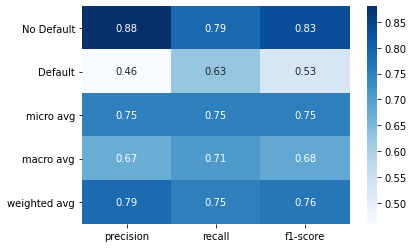

In [26]:
from sklearn.metrics import classification_report
class_rep1thresh = classification_report(y1Test, predprob_tuned_thresh1, output_dict=True, target_names= ['No Default', 'Default'])
# Create a dataframe from the dictionary and plot a heatmap of it.
#import seaborn as sns
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(class_rep1thresh).iloc[:-1, :].T, annot=True, cmap="Blues")

In [27]:
class_rep1thresh

{'No Default': {'precision': 0.879942487419123,
  'recall': 0.7881519639407598,
  'f1-score': 0.8315217391304348,
  'support': 4659},
 'Default': {'precision': 0.45977011494252873,
  'recall': 0.6263982102908278,
  'f1-score': 0.5303030303030303,
  'support': 1341},
 'micro avg': {'precision': 0.752,
  'recall': 0.752,
  'f1-score': 0.752,
  'support': 6000},
 'macro avg': {'precision': 0.6698563011808258,
  'recall': 0.7072750871157938,
  'f1-score': 0.6809123847167325,
  'support': 6000},
 'weighted avg': {'precision': 0.7860339621706042,
  'recall': 0.752,
  'f1-score': 0.76419935770751,
  'support': 6000}}

<AxesSubplot:>

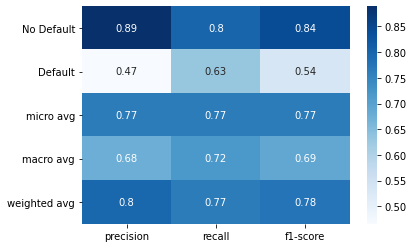

In [33]:
class_rep2thresh = classification_report(y2Test, predprob_tuned_thresh2, output_dict=True, target_names= ['No Default', 'Default'])
# Create a dataframe from the dictionary and plot a heatmap of it.
#import seaborn as sns
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(class_rep2thresh).iloc[:-1, :].T, annot=True, cmap="Blues")

In [34]:
class_rep2thresh

{'No Default': {'precision': 0.8892114175133043,
  'recall': 0.8026200873362446,
  'f1-score': 0.8436997934358504,
  'support': 4580},
 'Default': {'precision': 0.4657210401891253,
  'recall': 0.6324237560192616,
  'f1-score': 0.5364193328795099,
  'support': 1246},
 'micro avg': {'precision': 0.7662203913491246,
  'recall': 0.7662203913491246,
  'f1-score': 0.7662203913491246,
  'support': 5826},
 'macro avg': {'precision': 0.6774662288512148,
  'recall': 0.7175219216777531,
  'f1-score': 0.6900595631576802,
  'support': 5826},
 'weighted avg': {'precision': 0.7986400117210066,
  'recall': 0.7662203913491246,
  'f1-score': 0.7779820704950333,
  'support': 5826}}

<AxesSubplot:>

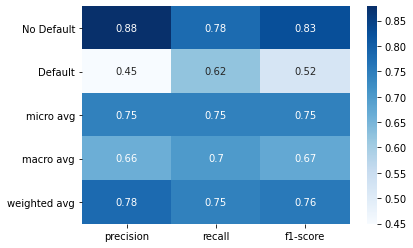

In [51]:
from sklearn.metrics import classification_report
class_rep1sthresh = classification_report(y1sTest, predprob_tuned_thresh1s, output_dict=True, target_names= ['No Default', 'Default'])
# Create a dataframe from the dictionary and plot a heatmap of it.
#import seaborn as sns
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(class_rep1sthresh).iloc[:-1, :].T, annot=True, cmap="Blues")

In [52]:
class_rep1sthresh

{'No Default': {'precision': 0.8778662804730871,
  'recall': 0.7806396222365315,
  'f1-score': 0.8264030902067712,
  'support': 4659},
 'Default': {'precision': 0.44964997307485194,
  'recall': 0.6226696495152871,
  'f1-score': 0.5222013758599124,
  'support': 1341},
 'micro avg': {'precision': 0.7453333333333333,
  'recall': 0.7453333333333333,
  'f1-score': 0.7453333333333332,
  'support': 6000},
 'macro avg': {'precision': 0.6637581267739695,
  'recall': 0.7016546358759093,
  'f1-score': 0.6743022330333418,
  'support': 6000},
 'weighted avg': {'precision': 0.7821599357695816,
  'recall': 0.7453333333333333,
  'f1-score': 0.7584140070502482,
  'support': 6000}}

<AxesSubplot:>

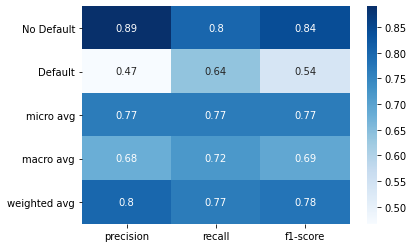

In [57]:
class_rep2sthresh = classification_report(y2sTest, predprob_tuned_thresh2s, output_dict=True, target_names= ['No Default', 'Default'])
# Create a dataframe from the dictionary and plot a heatmap of it.
#import seaborn as sns
# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(class_rep2sthresh).iloc[:-1, :].T, annot=True, cmap="Blues")

In [58]:
class_rep2sthresh

{'No Default': {'precision': 0.8904242424242425,
  'recall': 0.8019650655021834,
  'f1-score': 0.8438828259620907,
  'support': 4580},
 'Default': {'precision': 0.46678424456202233,
  'recall': 0.637239165329053,
  'f1-score': 0.5388530709195793,
  'support': 1246},
 'micro avg': {'precision': 0.766735324407827,
  'recall': 0.766735324407827,
  'f1-score': 0.766735324407827,
  'support': 5826},
 'macro avg': {'precision': 0.6786042434931324,
  'recall': 0.7196021154156182,
  'f1-score': 0.691367948440835,
  'support': 5826},
 'weighted avg': {'precision': 0.7998208374574856,
  'recall': 0.766735324407827,
  'f1-score': 0.778646458852072,
  'support': 5826}}

In [44]:
import joblib
# save the probility predictions
filename = 'LR_predProb.sav'
joblib.dump(LRpredprob_tuned_thresh, filename)

['LR_predProb.sav']